# Explaining the Effect of Gaps on Real/Lag-Domain Statistics

Up until now I've had some nice visualisations of the effect of gaps and lag-specific stats separately:

- case studies here and there
- streamlit dashboard (crashes)
- excel workbook (used to derive partial formula for sample size as a function of gap vector and lag)
- variogram clouds, tau-scattergrams
- error trendlines and heatmaps in latest paper

but what has been missing is a demonstration explaining the varying effect of gaps at different lags, especially the difference in how linear interpolation works and the effect of periodic gaps and any possible related `spectral inheritance'.

### CURRENTLY
- an interactive interface that allows specifying the gap vector for a given time series, and then the corresponding sample size at each lag
- a non-interactive strip plot and histogram showing how the difference distribution changes at selected lags with removal and interpolation

### TO-DO
- Make it so you can hover-over the strip plot and return an overlay on the time series, showing where the points in that diff are, like this: (CF DORSETH PAPER COMMENTS)

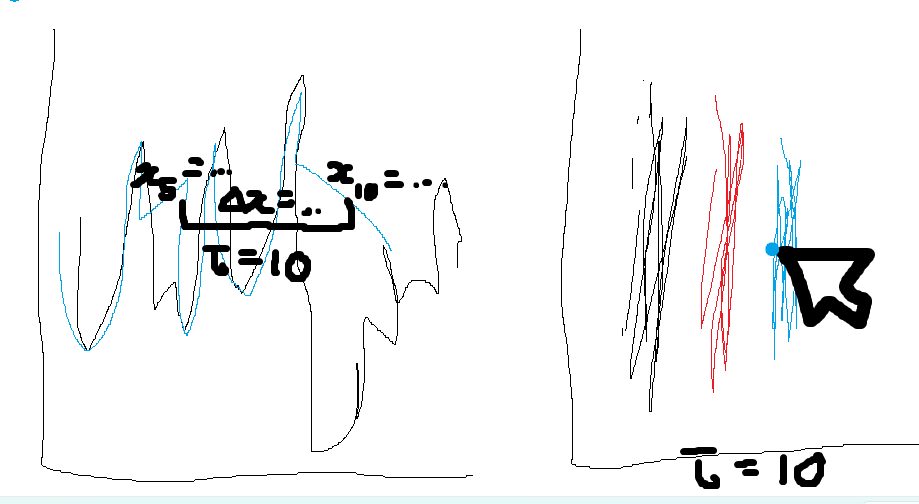

- The amount of metadata required above should also allow us to do the following: distinguish between diffs with just one or with both values removed.
- Make it so we can compare the sample size curve with resultant SF for periodic gaps, cf. Gallana ACF and Fraternale Voyager SF, in particular his sample size threshold. *Doesn't necessarily have to be interative*


Using this I can have some nice background for my thesis, and do more thorough formulations of the effect of gaps.

## Read data

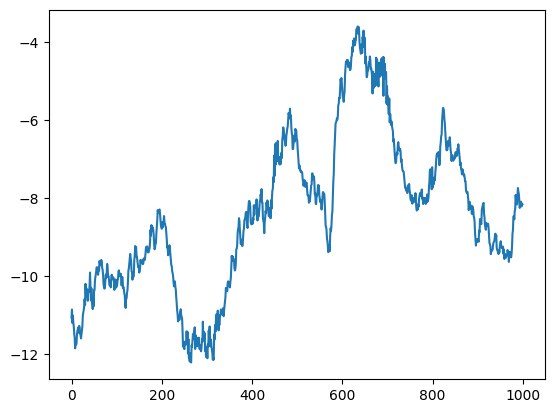

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tkinter import Tk, Label, Entry, Button
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import pandas as pd
import src.sf_funcs as sf
import src.ts_dashboard_utils as ts
import seaborn as sns

# Random walk
# np.random.seed(0)
# x = np.arange(0, 1000)
# y = np.cumsum(np.random.randn(1000))

# PSP data
psp = pd.read_pickle("psp_mag_scalar_int.pkl")
y = psp.values[:1000]
x = np.arange(0, len(y))
plt.plot(y)

## Compute SF and differences

In [2]:
good_output = sf.compute_sf(
    pd.DataFrame(y),
    np.arange(1, len(x)),
    [1, 2],
    retain_increments=True,
    alt_estimators=False,
)
good_output.head()

,lag,n,missing_percent,sf_1,sf_1_se,diffs_1,diffs_1_sd,sf_2,sf_2_se,diffs_2,diffs_2_sd
1,1,999,0.0,0.002907,0.006084,"[0.20715045928955078, -0.3437185287475586, 0.1...",0.192303,0.036952,0.002463,"[0.042911312783871836, 0.11814242700438626, 0....",0.077848
2,2,998,0.0,0.005630,0.007308,"[-0.1365680694580078, -0.1540842056274414, 0.0...",0.230860,0.053275,0.002463,"[0.018650837595487246, 0.023741942423839646, 9...",0.077806
3,3,997,0.0,0.008632,0.009715,"[0.053066253662109375, -0.33417797088623047, -...",0.306739,0.094069,0.004353,"[0.0028160272777313367, 0.1116749162256383, 0....",0.137455
4,4,996,0.0,0.011571,0.011582,"[-0.1270275115966797, -0.4321575164794922, -0....",0.365518,0.133603,0.006254,"[0.016135988702444592, 0.18676011904972256, 0....",0.197361
5,5,995,0.0,0.014640,0.013370,"[-0.2250070571899414, -0.6072454452514648, -0....",0.421741,0.177901,0.008440,"[0.05062817578527756, 0.3687470307786498, 0.14...",0.266241


In [3]:
def get_lag_vals_list(df):
    lag_vals_wide = pd.DataFrame(df["diffs_1"].tolist(), index=df.index)
    lag_vals_wide.reset_index(inplace=True)  # Make the index a column
    lag_vals_wide.rename(columns={"index": "lag"}, inplace=True)
    lag_vals = pd.melt(
        lag_vals_wide, id_vars=["lag"], var_name="index", value_name="diffs_1"
    )
    return lag_vals

In [4]:
# Convert to long format
lag_vals = get_lag_vals_list(good_output)
lag_vals
lag_vals_plot = lag_vals[lag_vals["lag"].isin([1, 5, 10, 20, 40])]


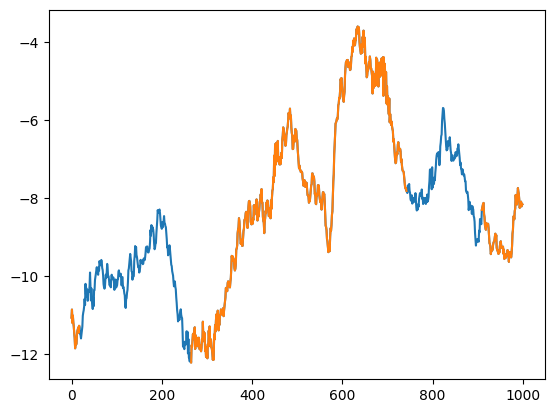

In [5]:
bad_input, bad_input_ind_chunks, prop_removed_chunks = ts.remove_data(
    pd.DataFrame(y), 0.5, chunks=np.random.randint(1, 10)
)
plt.plot(pd.DataFrame(y))
plt.plot(bad_input)

In [6]:
bad_output = sf.compute_sf(
    bad_input,
    np.arange(1, len(x)),
    [1, 2],
    retain_increments=True,
    alt_estimators=False,
)

lag_vals_bad = get_lag_vals_list(bad_output)

In [7]:
interp_input = (
    bad_input.interpolate(method="linear").ffill().bfill()
)  # Linearly interpolate (and, in case of missing values at edges, back and forward fill)
interp_output = sf.compute_sf(
    pd.DataFrame(interp_input),
    np.arange(1, len(x)),
    [1, 2],
    retain_increments=True,
    alt_estimators=False,
)
lag_vals_interp = get_lag_vals_list(interp_output)

In [8]:
lag_vals["status"] = "original"
lag_vals_copy = lag_vals.copy()
lag_vals_copy["removed"] = ~lag_vals["diffs_1"].isin(lag_vals_bad["diffs_1"])
lag_vals_minus_missing = lag_vals_copy[lag_vals_copy["removed"] == 0]
lag_vals_minus_missing["status"] = "gapped"
lag_vals_interp["status"] = "interpolated"
lag_vals_removed = lag_vals_copy[lag_vals_copy["removed"]]
lag_vals_removed["status"] = "removed"
lag_vals_interp["interp"] = ~lag_vals_interp["diffs_1"].isin(lag_vals["diffs_1"])
lag_vals_interped = lag_vals_interp[lag_vals_interp["interp"]]
lag_vals_interped["status"] = "interpolated"

lag_vals_all = pd.concat([lag_vals, lag_vals_removed, lag_vals_interped])
lag_vals_all.reset_index(inplace=True)

print(lag_vals_all.status.value_counts())


C:\Users\spann\AppData\Local\Temp\ipykernel_28644\2320790778.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lag_vals_minus_missing["status"] = "gapped"
C:\Users\spann\AppData\Local\Temp\ipykernel_28644\2320790778.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lag_vals_removed["status"] = "removed"
C:\Users\spann\AppData\Local\Temp\ipykernel_28644\2320790778.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

original        999000
interpolated    327503
removed         324405
Name: status, dtype: int64


## Strip plot

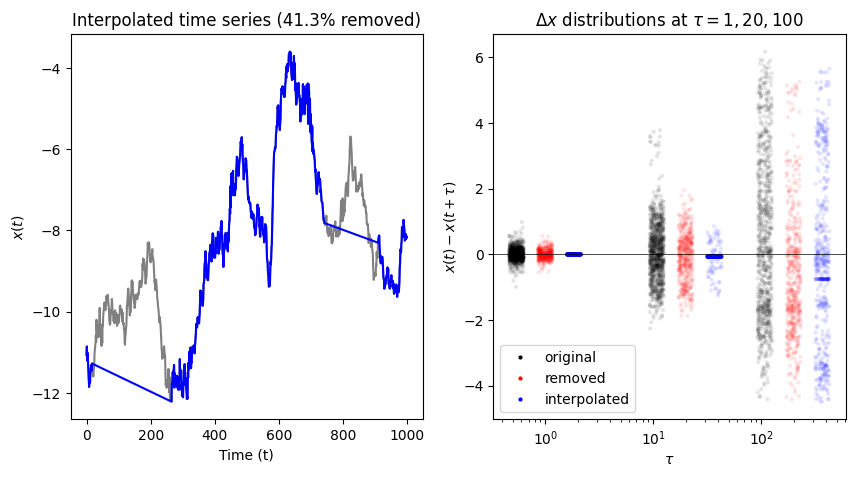

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# TIME SERIES

ax[0].plot(pd.DataFrame(y), label="Original", color="grey")
ax[0].plot(interp_input, label="Interpolated", color="blue")

ax[0].set_xlabel("Time (t)")
ax[0].set_ylabel("$x(t)$")
ax[0].set_title(f"Interpolated time series ({prop_removed_chunks*100}% removed)")

# LAG DISTRIBUTIONS

sns.stripplot(
    data=lag_vals_all[lag_vals_all["lag"].isin([1, 20, 200])],
    x="lag",
    y="diffs_1",
    hue="status",
    dodge=True,
    jitter=0.2,
    palette={"original": "black", "removed": "red", "interpolated": "blue"},
    native_scale=True,
    log_scale=[True, False],
    zorder=1,
    size=3,
    alpha=0.1,
    ax=ax[1],
)

ax[1].set_xlabel("$\\tau$")
ax[1].set_ylabel("$x(t)-x(t+\\tau)$")
ax[1].set_title("$\Delta x$ distributions at $\\tau=1,20,100$")

# Move legend to beneath plot
handles, labels = ax[1].get_legend_handles_labels()
for handle in handles:
    handle.set_alpha(1)  # Set alpha to 1 for all handles
ax[1].legend(handles, labels, loc="lower left")

# Add a horizontal line at y=0
ax[1].axhline(0, color="black", linewidth=0.5)

plt.show()

## Histograms

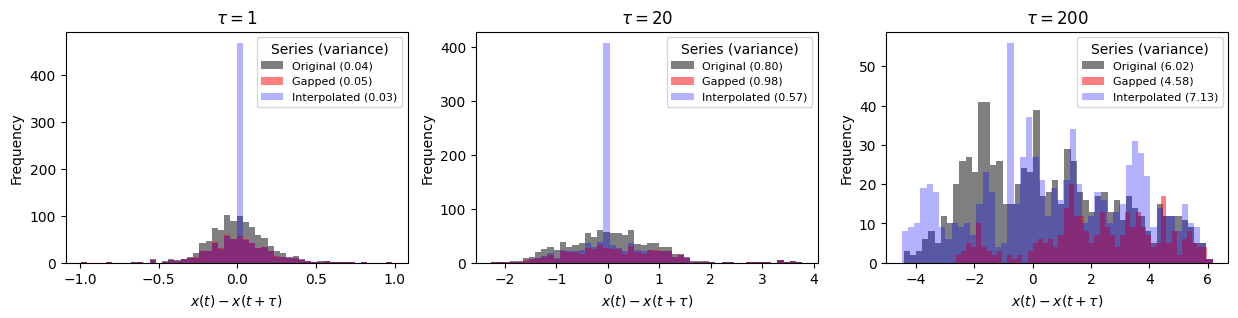

In [10]:
# Plot histograms for the rows where lag = 1, 10, and 100
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
for i, lag in enumerate([1, 20, 200]):
    ax[i].hist(
        lag_vals[lag_vals["lag"] == lag]["diffs_1"],
        bins=50,
        alpha=0.5,
        color="black",
        label=f"Original ({np.var(lag_vals[lag_vals['lag'] == lag]['diffs_1']):.2f})",
    )
    lag_vals_minus_missing = lag_vals_copy[lag_vals_copy["removed"] == 0]
    ax[i].hist(
        lag_vals_minus_missing[lag_vals_minus_missing["lag"] == lag]["diffs_1"],
        bins=50,
        alpha=0.5,
        color="red",
        label=f"Gapped ({np.var(lag_vals_minus_missing[lag_vals_minus_missing['lag'] == lag]['diffs_1']):.2f})",
    )
    ax[i].hist(
        lag_vals_interp[lag_vals_interp["lag"] == lag]["diffs_1"],
        bins=50,
        alpha=0.3,
        color="blue",
        label=f"Interpolated ({np.var(lag_vals_interp[lag_vals_interp['lag'] == lag]['diffs_1']):.2f})",
    )

    ax[i].set_title(f"$\\tau={lag}$")
    ax[i].legend(
        title="Series (variance)",
        title_fontsize="10",
        fontsize="8",
        # frameon=True,
        # loc="upper right",
        # framealpha=0.9,
        # borderpad=1,
    )
    ax[i].set_xlabel("$x(t) - x(t+\\tau)$")
    ax[i].set_ylabel("Frequency")
plt.show()

## Get modes of distributions

In [11]:
# Group by var1 and var2, and count occurrences of 'values'
most_common = (
    lag_vals_all[lag_vals_all["lag"].isin([1, 10, 100])]
    .groupby(["lag", "status"])["diffs_1"]
    .value_counts()  # Get counts of 'values'
    .groupby(level=[0, 1])  # Group by var1 and var2
    .head(5)  # Select top 5 for each group
    .reset_index(name="count")
)  # Reset index and name the count column

# Display the result
print(most_common)

    lag        status   diffs_1  count
0     1  interpolated -0.003780    208
1     1  interpolated -0.002895     86
2     1  interpolated -0.002895     44
3     1  interpolated -0.003780     40
4     1  interpolated -0.002895     37
5     1      original -0.003662      2
6     1      original -0.991658      1
7     1      original -0.806547      1
8     1      original -0.669881      1
9     1      original -0.610868      1
10    1       removed -0.552616      1
11    1       removed -0.525693      1
12    1       removed -0.474345      1
13    1       removed -0.427866      1
14    1       removed -0.407842      1
15   10  interpolated -0.037797    149
16   10  interpolated -0.037797     90
17   10  interpolated -0.028947     58
18   10  interpolated -0.028947     54
19   10  interpolated -0.028947     46
20   10      original -1.463303      1
21   10      original -1.412543      1
22   10      original -1.327351      1
23   10      original -1.305115      1
24   10      original -1.


## Interactive gap removal

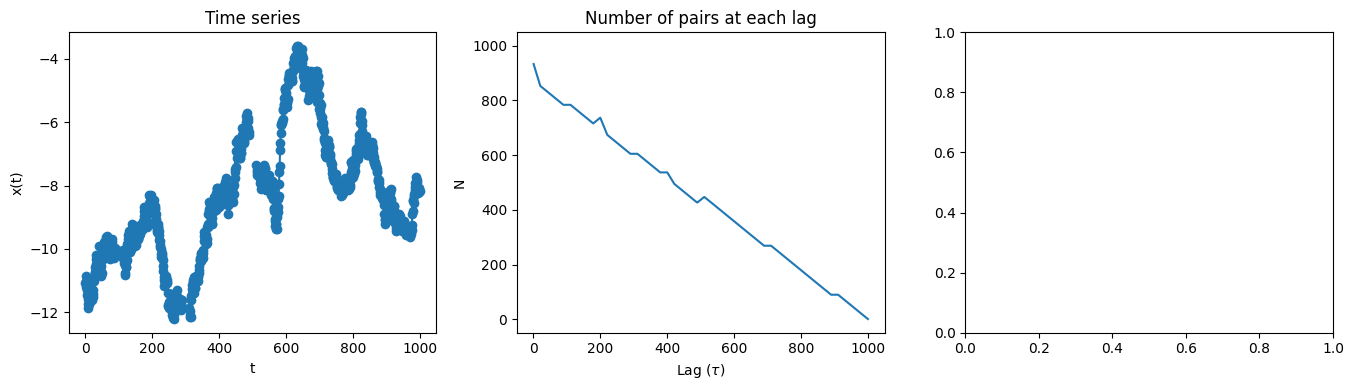

In [12]:
# Create a Tkinter window
root = Tk()
root.title("The Effect of Gaps on Lag-Domain Statistics")

# Create figure and two axes: one for the time series and one for the histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)

# Plot the time series
(line,) = ax1.plot(x, y, "o-", label="Time Series")
ax1.set_title("Time series")
ax1.set_xlabel("t")
ax1.set_ylabel("x(t)")

# Plot the initial histogram
# hist_data = y[~np.isnan(y)]  # Exclude NaN values for histogram
(sample_size_line,) = ax2.plot(good_output["lag"], good_output["n"])
ax2.set_title("Sample size for each lag")
ax2.set_xlabel("Lag ($\\tau$)")
ax2.set_ylabel("N")


# Function to parse indexes, handle ranges (e.g., "5-10") and single values
def parse_indexes(indexes):
    remove_idx = set()  # Use a set to avoid duplicate entries

    # Split the input string by commas and process each part
    for part in indexes.split(","):
        part = part.strip()

        # Handle ranges like "5-10"
        if "-" in part:
            start, end = part.split("-")
            remove_idx.update(range(int(start), int(end) + 1))
        elif part.isdigit():  # Handle single numbers
            remove_idx.add(int(part))

    return list(remove_idx)


# Function to remove points and update both the time series and histogram
def remove_points():
    try:
        # Get the input from the entry field (indexes separated by commas or ranges)
        indexes = entry.get()

        # Parse the indexes, allowing for ranges and single values
        remove_idx = parse_indexes(indexes)

        # Create a copy of y to modify (set values at the selected indexes to NaN)
        y_masked = y.copy()
        y_masked[remove_idx] = np.nan  # Set selected points to NaN to create gaps

        # Update the data for the time series plot
        line.set_data(x, y_masked)

        # Adjust limits for the time series plot
        # ax1.relim()
        # ax1.autoscale_view()

        # Update the histogram with non-NaN values
        # ax2.cla()  # Clear the current histogram

        good_output_new = sf.compute_sf(
            pd.DataFrame(y_masked),
            np.arange(1, len(x)),
            [1, 2],
            retain_increments=True,
            alt_estimators=False,
        )

        sample_size_line.set_data(good_output_new["lag"], good_output_new["n"])
        ax2.set_title("Number of pairs at each lag")

        # Redraw the updated plots
        canvas.draw()  # This explicitly updates the canvas

    except Exception as e:
        print(f"Error: {e}")


# Create label and entry field for user input
label = Label(root, text="Define gap vector G (e.g., 3, 5-10):")
label.pack()

entry = Entry(root)
entry.pack()

# Button to trigger point removal
button = Button(root, text="Remove Points", command=remove_points)
button.pack()

# Create a `matplotlib` figure and embed it in the Tkinter window
canvas = FigureCanvasTkAgg(fig, master=root)
canvas.get_tk_widget().pack()

# Display the initial plot and start Tkinter's event loop
canvas.draw()
root.mainloop()
